## Bagging
This method will use **bagging** for **positive-unlabeled** classifier learning [(Mordelet and Vert, 2014)](https://www.sciencedirect.com/science/article/pii/S0167865513002432?via%3Dihub)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Randomly choose other datapoints to also be positive, and make all others negative
3. Rinse and repeat, aggregating classification scores

In [243]:
import sys
sys.path.append('../')
from QC import *
from PU_bagging import *
sc.settings.set_figure_params(dpi=80)

In [205]:
# reload fcc module while working
import sys
del sys.modules['QC']
from QC import *

### Load data and preprocess

Read in normal human colon sample

In [206]:
%time s1 = sc.read_h5ad('../data/2771-AS-1-GCCAAT_S1.h5ad')

CPU times: user 5.25 s, sys: 300 ms, total: 5.55 s
Wall time: 5.53 s


In [207]:
s1 # see what's in our object

AnnData object with n_obs × n_vars = 8064 × 38459 
    obs: 'ken_filter'

In [208]:
s1.raw = s1 # save raw counts for later filtering

In [209]:
#s1.obs["ken_filter"]

In [210]:
# add thresholding results
thresholded = pd.read_csv("thresholded-2771-S1.csv")

In [212]:
s1.obs

ken_filter
index             
bcEBWV           1
bcHTFJ           0
bcFCVP           1
bcHBHC           1
bcAMGS           1
...            ...
bcHZBT           0
bcGZGG           0
bcIDGP           0
bcIIIM           0
bcFUWU           0

[8064 rows x 1 columns]

In [213]:
thresholded

barcode  train_li  train_mean  train_real_max  total_counts  \
0     bcEBWV         0           0               0       15944.0   
1     bcFCVP         0           0               0       15041.0   
2     bcHTFJ         0           0               0       14056.0   
3     bcHNVN         0           0               0       11987.0   
4     bcBHXW         0           0               0       11638.0   
...      ...       ...         ...             ...           ...   
8059  bcDIYW         1           1               1         163.0   
8060  bcDARA         1           1               0         158.0   
8061  bcIDNH         1           1               1         156.0   
8062  bcGLVO         1           1               1         156.0   
8063  bcFJXN         0           0               1         156.0   

      log1p_total_counts  n_counts  pct_counts_mito  
0               9.676901       NaN        19.323883  
1               9.618602       NaN         0.292534  
2               9.550876       NaN         7.434548  
3               9.391662       NaN         6.340202  
4               9.362117       NaN         9.374463  
...                  ...       ...              ...  
8059            5.099866       NaN        25.766870  
8060            5.068904       NaN        74.050640  
8061            5.056246       NaN        36.538460  
8062            5.056246       NaN        12.179487  
8063            5.056246       NaN        15.384616  

[8064 rows x 8 columns]

In [214]:
#thresholded["ken_filter"] = s1.obs["ken_filter"]

In [215]:
#s1.obs = thresholded.copy()

In [216]:
# only use when barcode data type does not match with index data type
thresholded.barcode = thresholded.barcode.astype(str)

In [217]:
s1.obs = s1.obs.merge(thresholded, left_on = 'index', right_on = 'barcode')

AnnData expects string indices for some functionality, but your first two indices are: Int64Index([0, 1], dtype='int64'). 


In [218]:
s1.obs

ken_filter barcode  train_li  train_mean  train_real_max  total_counts  \
0              1  bcEBWV         0           0               0       15944.0   
1              0  bcHTFJ         0           0               0       14056.0   
2              1  bcFCVP         0           0               0       15041.0   
3              1  bcHBHC         0           0               0        9700.0   
4              1  bcAMGS         0           0               0        7786.0   
...          ...     ...       ...         ...             ...           ...   
8059           0  bcHZBT         1           1               1         180.0   
8060           0  bcGZGG         1           1               0         190.0   
8061           0  bcIDGP         1           0               1         195.0   
8062           0  bcIIIM         1           1               0         228.0   
8063           0  bcFUWU         1           1               0         180.0   

      log1p_total_counts  n_counts  pct_counts_mito  
0               9.676901       NaN        19.323883  
1               9.550876       NaN         7.434548  
2               9.618602       NaN         0.292534  
3               9.179984       NaN         5.061855  
4               8.960211       NaN         3.930131  
...                  ...       ...              ...  
8059            5.198497       NaN        16.666668  
8060            5.252274       NaN        49.473686  
8061            5.278115       NaN        47.179490  
8062            5.433722       NaN        36.403510  
8063            5.198497       NaN        40.000000  

[8064 rows x 9 columns]

### Find inflection point

In [219]:
#find_inflection(s1, inflection_percentiles = [0,20,40,70,100])

In [220]:
#s1.obs['total_counts'][13918] # see the total counts at 80th percentile of secant distance (beyond inflection point)

In [185]:
# create new "observation" as empty droplet label
#s1.obs['bagging_empty'] = np.where(s1.obs['total_counts']<=s1.obs['total_counts'][13918], 1, 0) # 1 is "empty", 0 is __initially__ "not empty"

In [186]:
#s1.obs['bagging_empty'].value_counts()

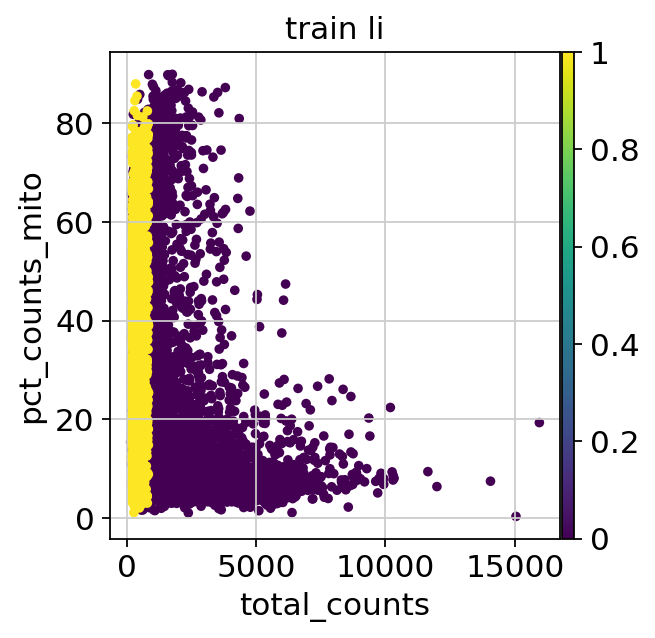

In [221]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='train_li', size=75)

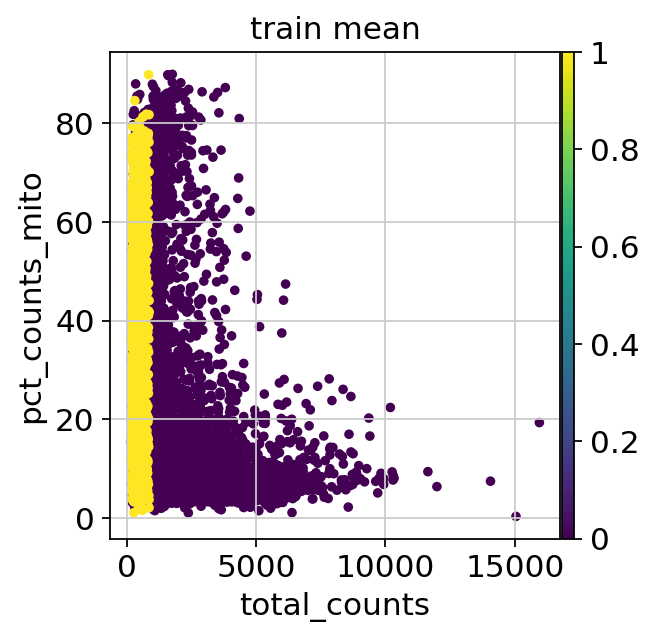

In [222]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='train_mean', size=75)

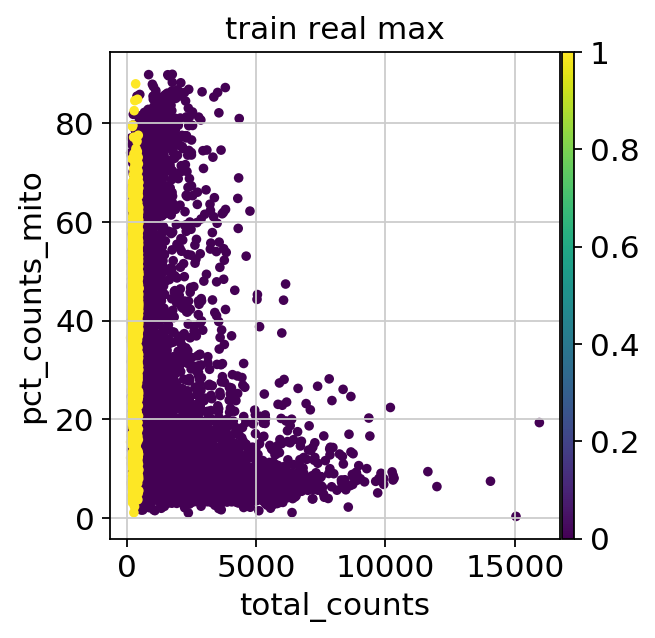

In [223]:
# look at the training labels we've picked
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='train_real_max', size=75)

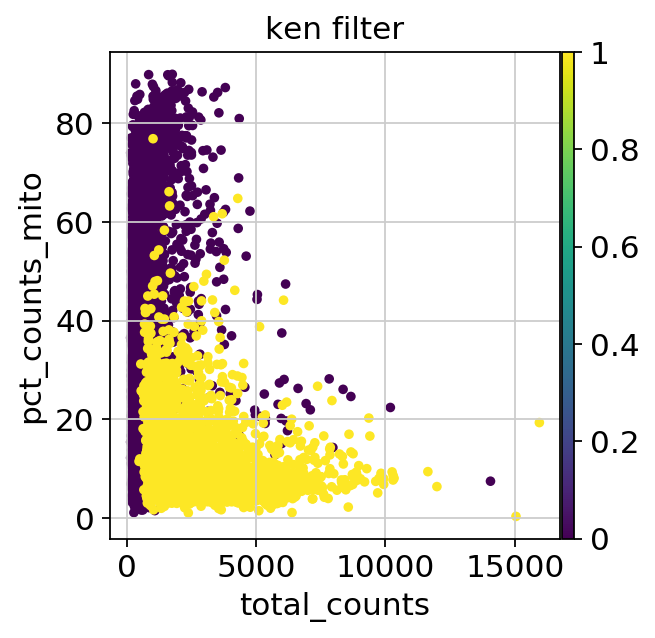

In [224]:
# look at our previously-defined labels
sc.pl.scatter(s1, x='total_counts', y='pct_counts_mito', color='ken_filter', size=75)

### Normalize and perform linear dimensionality reduction with PCA
Principal components will be fed into classifiers to speed up processing time by reducing gene dimensions to 100 from 40k+.

In [225]:
%%time
sc.pp.normalize_total(s1, target_sum=10000) # each gene count value is divided by the total number of counts for that respective cell  
sc.pp.log1p(s1) # log1p transformation
sc.pp.scale(s1, max_value=10) # scaling by variance and centering to zero for visualization

CPU times: user 2.18 s, sys: 115 ms, total: 2.29 s
Wall time: 2.29 s


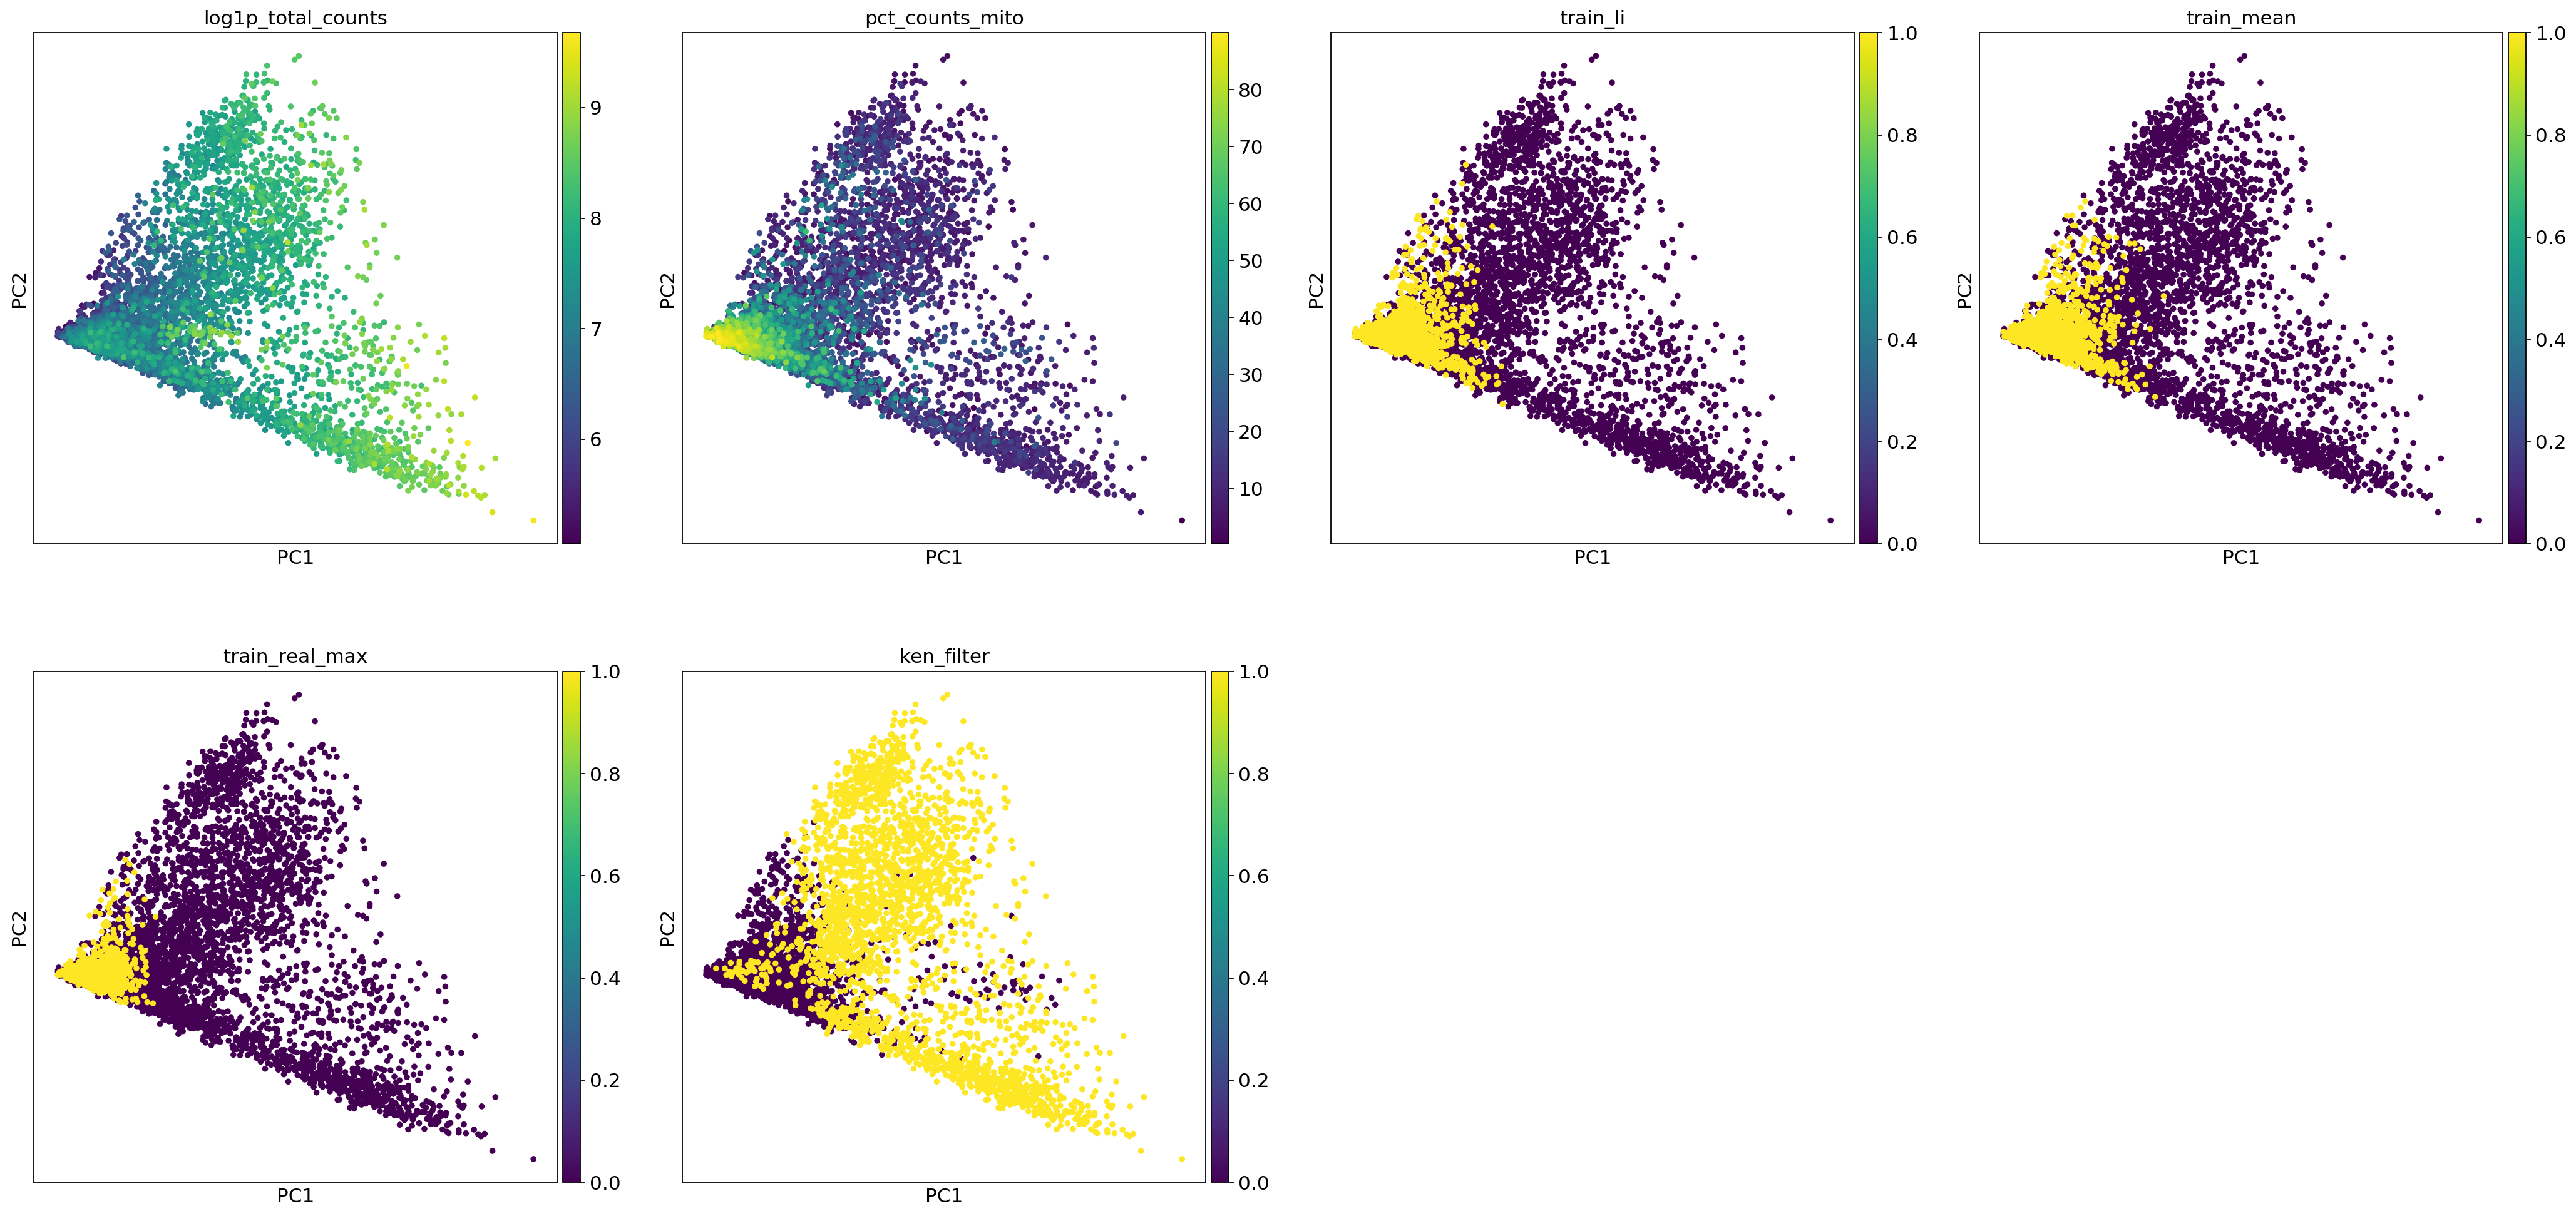

CPU times: user 3min 40s, sys: 1min 29s, total: 5min 9s
Wall time: 9.29 s


In [254]:
%%time
sc.tl.pca(s1, n_comps=100) # perform PCA and plot results
sc.pl.pca(s1, color=['log1p_total_counts','pct_counts_mito','train_li', 'train_mean', 'train_real_max', 'ken_filter'], ncols=4, size=75)

In [259]:
# define X and y for classifier training for simplicity
X1 = s1.obsm['X_pca'] # training data is PCA results
y1 = s1.obs['train_li'].copy(deep=True) # training labels are from .obs df
y2 = s1.obs['train_mean'].copy(deep=True) # training labels are from .obs df
y3 = s1.obs['train_real_max'].copy(deep=True) # training labels are from .obs df

In [277]:
# train li
%%time
bc1 = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y1), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc1.fit(X1, y1)

results_bagging_li = bc1.oob_decision_function_[:,1]

UsageError: Line magic function `%%time` not found.


In [261]:
# train mean
%%time
bc2 = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y2), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc2.fit(X1, y2)

results_bagging_mean = bc2.oob_decision_function_[:,1]

UsageError: Line magic function `%%time` not found.


In [262]:
# train real max
%%time
bc3 = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y3), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc3.fit(X1, y3)

results_bagging_real_max = bc3.oob_decision_function_[:,1]

UsageError: Line magic function `%%time` not found.


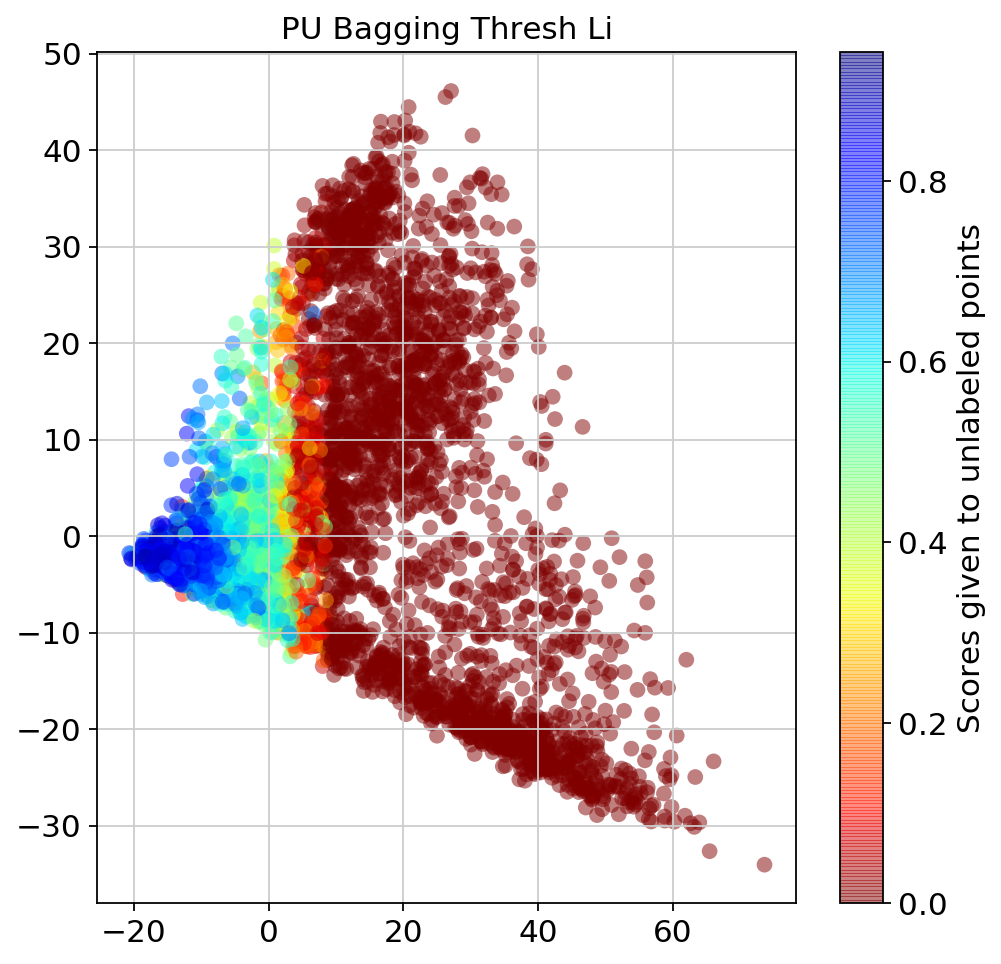

In [264]:
# train li
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_li, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging Thresh Li')
plt.show()

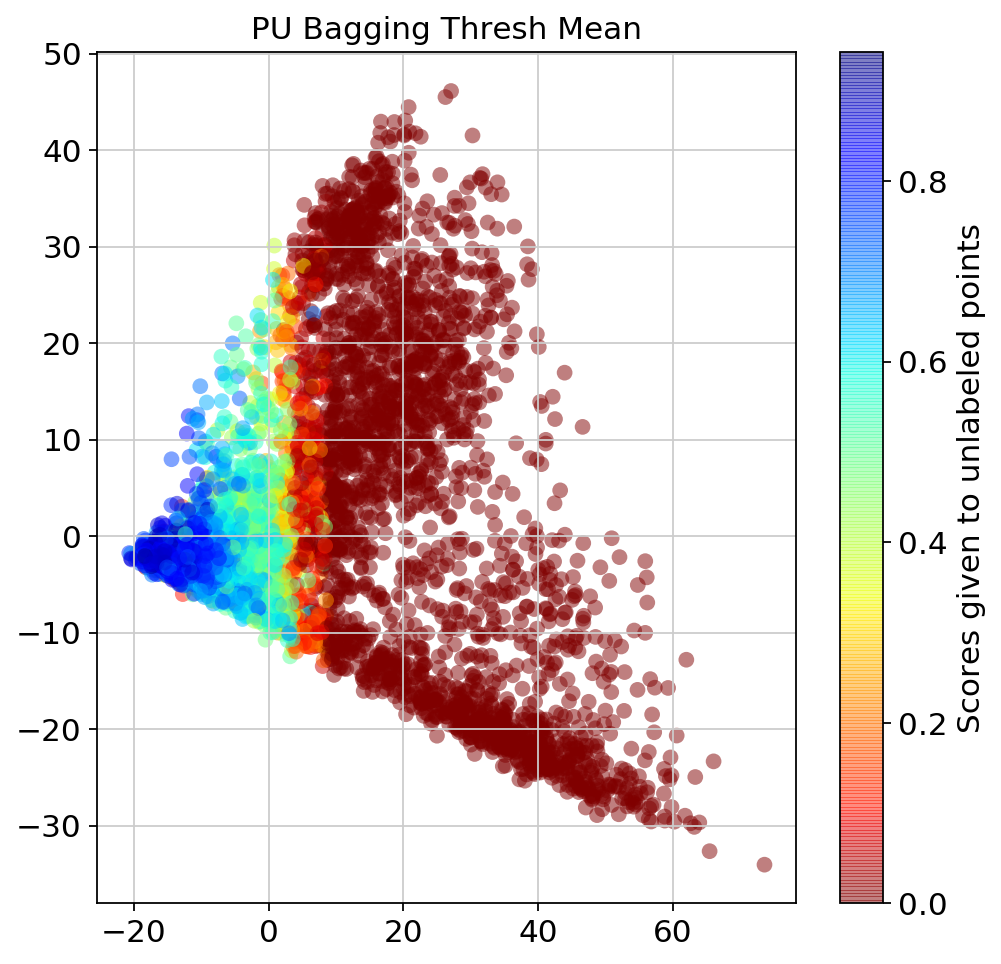

In [249]:
# train mean
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_li, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging Thresh Mean')
plt.show()

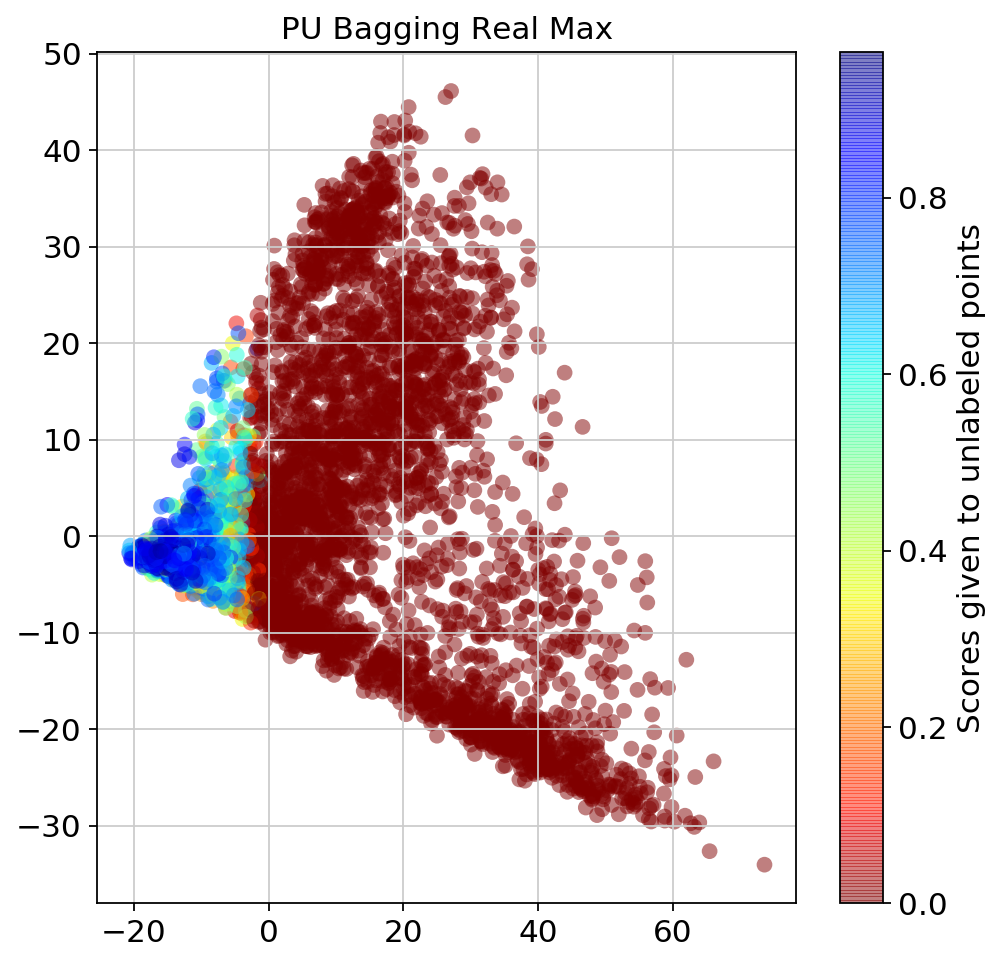

In [250]:
# train real max
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = results_bagging_real_max, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging Real Max')
plt.show()

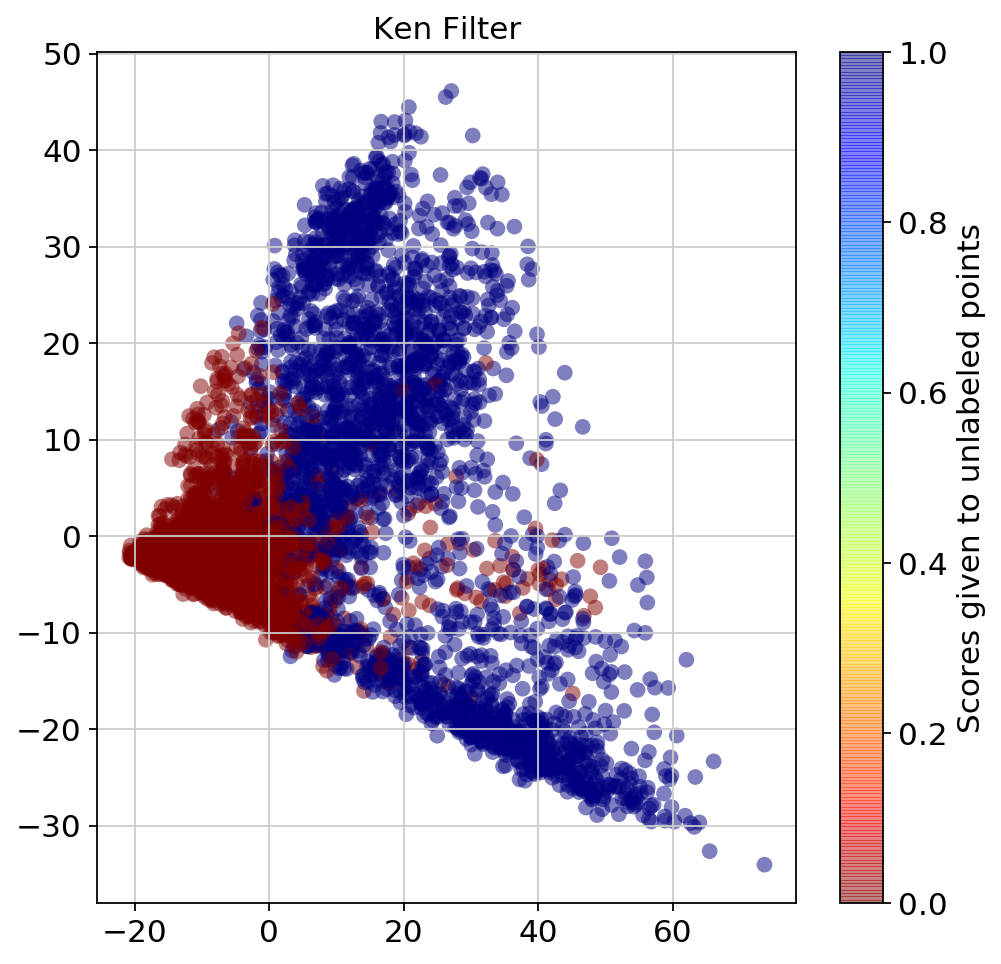

In [269]:
# ken filter
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    X[:,0], X[:,1], 
    c = s1.obs['ken_filter'], linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Ken Filter')
plt.show()

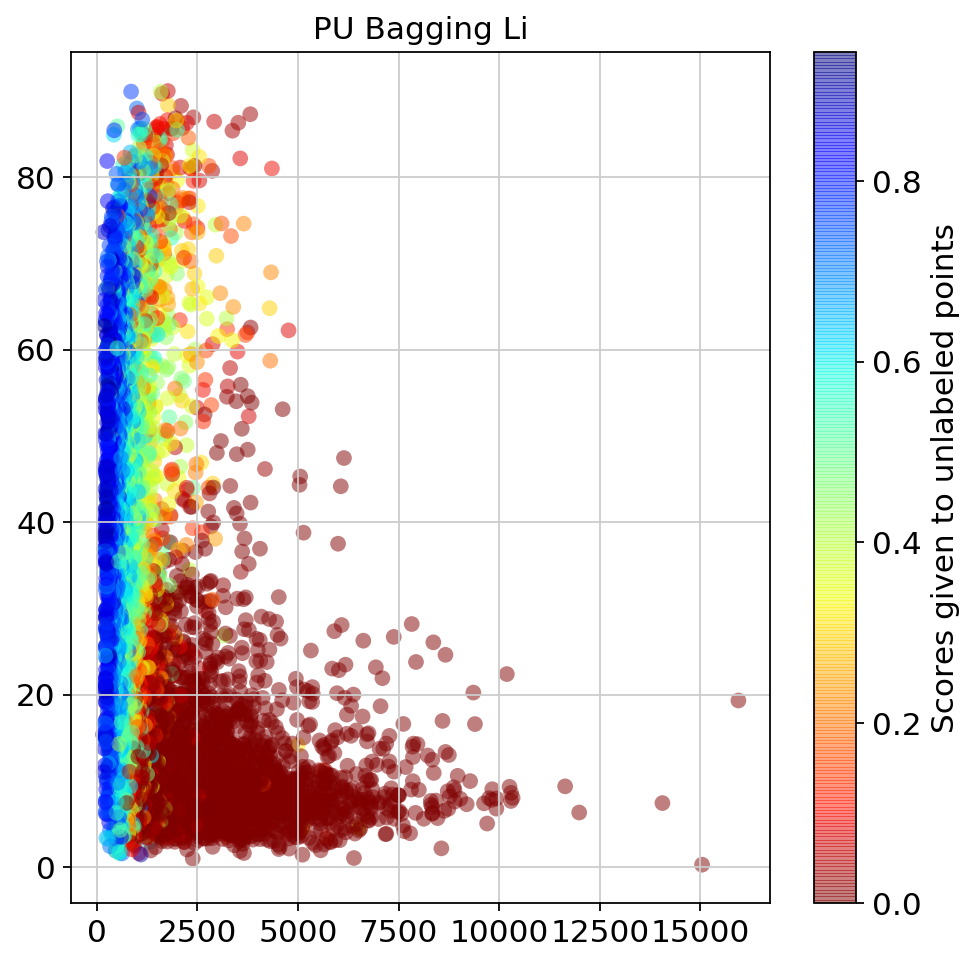

In [252]:
# train li
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = results_bagging_li, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging Li')
plt.show()

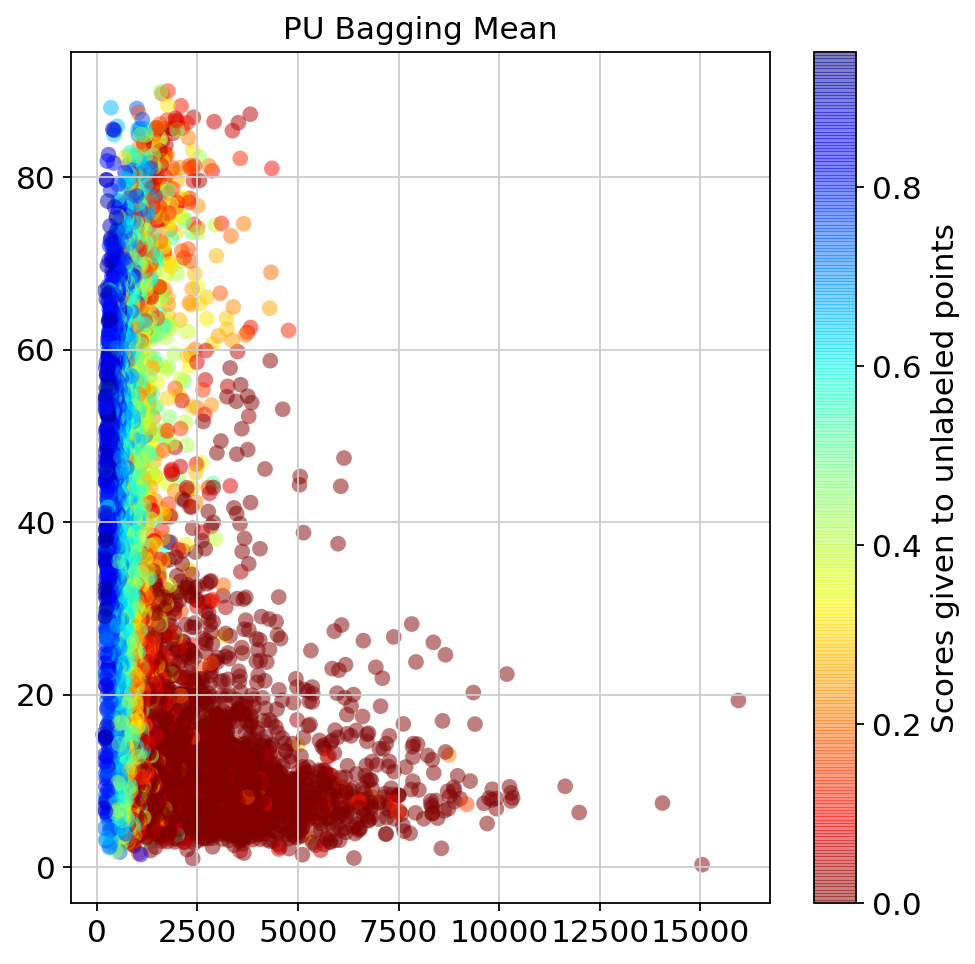

In [251]:
# train mean
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = results_bagging_mean, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging Mean')
plt.show()

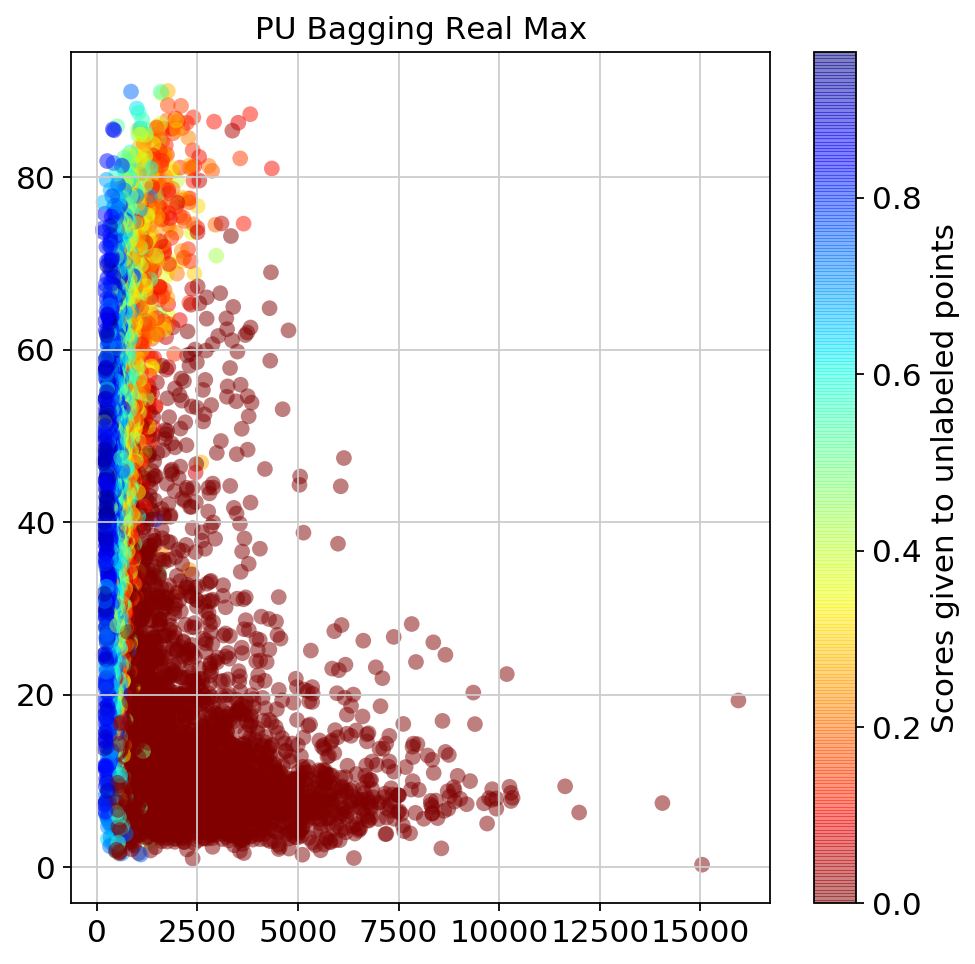

In [253]:
# train real max
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = results_bagging_real_max, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU Bagging Real Max')
plt.show()

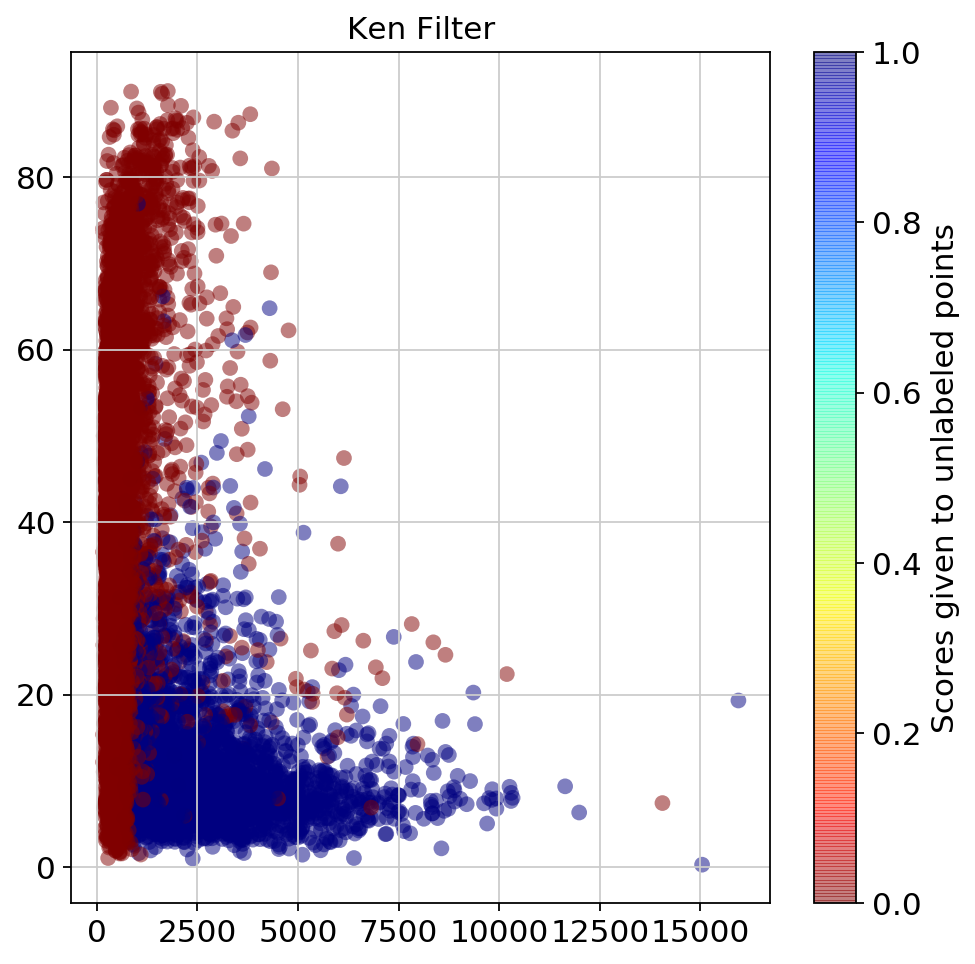

In [268]:
# ken's filter
# visualize PU bagging results
plt.rcParams['figure.figsize'] = 7,7
plt.scatter(
    s1.obs['total_counts'], s1.obs['pct_counts_mito'], 
    c = s1.obs["ken_filter"], linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Ken Filter')
plt.show()